<a href="https://colab.research.google.com/github/maverick-0215/Fairness-via-Continual-Learning/blob/main/Testing_EWC_on_permuted_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def train(model, train_loader, criterion, optimizer, device, max_epochs=10, patience=6):
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(max_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in train_loader:
            if len(batch)==2:
              inputs,labels=batch
            if len(batch) == 3:
                inputs, labels, _ = batch
            elif len(batch) == 4:
                inputs, labels, _, _ = batch


            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute EWC Loss
            ewc_loss = 0.0
            # for (name, param), (_, old_param) in zip(model.named_parameters(), old_params.items()):
            #     if name in fisher_information:
            #         ewc_loss += (fisher_information[name] * (param - old_param).pow(2)).sum()

            total_loss = loss
            total_loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = 100 * correct / total

        # Early stopping condition
        if train_loss < best_loss:
            best_loss = train_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return train_loss, train_acc

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[900, 900], output_size=10, dropout_prob=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Function to calculate Fisher Information
def calculate_fisher_information(model, data_loader, criterion, device):
    fisher_information = {}
    model.eval()
    for name, param in model.named_parameters():
        fisher_information[name] = torch.zeros_like(param)

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        for name, param in model.named_parameters():
            fisher_information[name] += param.grad ** 2 / len(data_loader)

    return fisher_information



def train_with_ewc(model, train_loader, criterion, optimizer, fisher_information, old_params, device,
                    ewc_lambda=0.5, max_epochs=100, patience=6):
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(max_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in train_loader:
            if len(batch) == 3:
                inputs, labels, _ = batch
            elif len(batch) == 4:
                inputs, labels, _, _ = batch
            else:
                raise ValueError(f"Unexpected batch format: {len(batch)} elements")

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute EWC Loss
            ewc_loss = 0.0
            for (name, param), (_, old_param) in zip(model.named_parameters(), old_params.items()):
                if name in fisher_information:
                    ewc_loss += (fisher_information[name] * (param - old_param).pow(2)).sum()

            total_loss = loss + (ewc_lambda * ewc_loss)
            total_loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = 100 * correct / total

        # Early stopping condition
        if train_loss < best_loss:
            best_loss = train_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return train_loss, train_acc



# Function to test model
def test_task(model, data_loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    return 100.0 * correct / total

# Function to permute MNIST data
def permute_data(dataset, perm):
    permuted_data = []
    for img, label in dataset:
        img = img.view(-1)[perm].view(1, 28, 28)
        permuted_data.append((img, label))
    return permuted_data

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model, loss, optimizer
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Load Original MNIST
data_transform = transforms.Compose([transforms.ToTensor()])
original_train = datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
original_test = datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)
original_train_loader = torch.utils.data.DataLoader(original_train, batch_size=64, shuffle=True)
original_test_loader = torch.utils.data.DataLoader(original_test, batch_size=64, shuffle=False)

# Train on Original MNIST for 100 epochs
print("\nTraining on Task 0 (Original MNIST)")
for epoch in range(100):
    train_loss_0, train_acc_0 = train(model, original_train_loader, criterion, optimizer, device)


# Test on Original MNIST
test_acc_0 = test_task(model, original_test_loader, device)
print(f"Task 0 - Test Accuracy: {test_acc_0:.2f}%")

# Calculate Fisher Information
fisher_information = calculate_fisher_information(model, original_train_loader, criterion, device)
old_params = {name: param.clone().detach() for name, param in model.named_parameters()}

# Training on Permuted MNIST tasks
num_tasks = 10
original_test_accuracies = []
for task in range(1, num_tasks + 1):
    perm = np.random.permutation(28 * 28)
    permuted_train = permute_data(original_train, perm)
    train_loader = torch.utils.data.DataLoader(permuted_train, batch_size=64, shuffle=True)

    print(f"\nTraining on Task {task} (Permuted MNIST)")
    train_loss, train_acc = train_with_ewc(model, train_loader, criterion, optimizer, fisher_information, old_params, device)
    print(f"Task {task} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

    # Test on Original MNIST
    test_acc = test_task(model, original_test_loader, device)
    original_test_accuracies.append(test_acc)
    print(f"Test Accuracy on Original MNIST after Task {task}: {test_acc:.2f}%")

    # Update Fisher Information and Old Parameters
    fisher_information = calculate_fisher_information(model, train_loader, criterion, device)
    old_params = {name: param.clone().detach() for name, param in model.named_parameters()}



Training on Task 0 (Original MNIST)


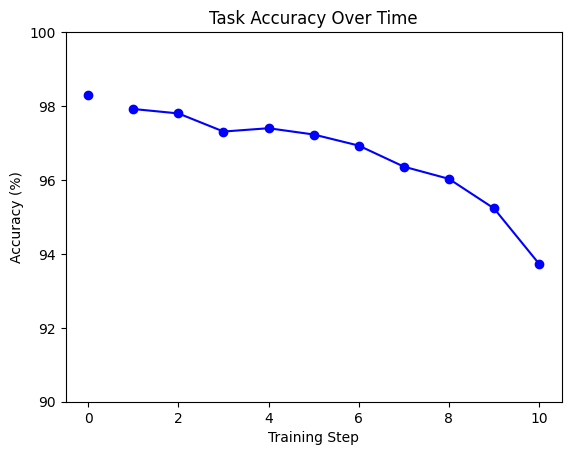

In [ ]:
# Plotting Accuracies+
import matplotlib.pyplot as plt
id=[]
for i in range(1,11):
    id.append(i)
plt.plot(0,test_acc_0, marker='o', linestyle='-', color='b')
plt.plot(id, original_test_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Training Step')
plt.ylabel('Accuracy (%)')
plt.ylim(90,100)
plt.title('Task Accuracy Over Time')
plt.show()
